In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv

import numpy as np
import random
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler


import sys
sys.path.insert(0, "../utils/")
import utils as ut

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

from keras import backend as K

## Input options

In [3]:
features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'theta', 'q', 'Mc'];
regr_data_dir    = '../NewRealistic/'
write_output     = False
out_data_dir     = '../NNtf_results/'
versions         = ['0'] # can be a subset of ['0', '1', '2']
clabels          = ['0'] # can be a subset of ['0', '1'] 

# sample size (fixed, do not modify)
Ntrain           = 20000
Ntest            = 15000
remove_some_mass = True

# training options
epochs           = 50
validation_split = 0.2
batch_size       = 64
verbose_training = 1
hlayers_sizes    = [150, 150];
learning_rate    = 0.0001
scaler_str       = 'mixed'  # standard, minmax, mixed
activation       = 'relu'
out_activation   = 'linear_cut' # sigmoid, linear, linear_cut, linear_cut_T3

## Check on input and dictionary-initialization

In [4]:
Nfeatures  = len(features_names)

# define dictionary for each version considered
Nv       = len(versions)
Nc       = len(clabels)
Nsets    = Nv*Nc

if Nv*Nc!=Nsets:
    print('+++ Wrong input! +++')

datasets = {}
keys     = []
for i in range(0,Nv):
    version = versions[i]
    for j in range(0,Nc):
        clabel = clabels[j]
        key = 'v'+version+'c'+clabel
        keys.append(key)
        datasets[key]         = lambda:0
        datasets[key].clabel  = clabel
        datasets[key].version = version
        datasets[key].Ntrain  = Ntrain
        datasets[key].Ntest   = Ntest

In [5]:
# define the ouput activation according to the input
if out_activation=="sigmoid":
    def output_activation(x):
        return K.sigmoid(x)*2-1

elif out_activation=="linear":
    def output_activation(x):
        return x

elif out_activation=="linear_cut":
    def output_activation(x):
        signs = K.switch(x>0, 1+x*0, -1+x*0) # x*0 in order to broadcast to correct dimension
        return K.switch(abs(x)<1, x, signs)

elif out_activation=="linear_cut_T3":
    def output_activation(x):
        return 2/(K.exp(-(2*x+2/3*x*x*x))+1)-1

# define model
def buildModelUsingSequential(hlayers_sizes, batch_size, Nfeatures):
    model = Sequential()
    for i in range(0, len(hlayers_sizes)):
        model.add(Dense(hlayers_sizes[i], kernel_initializer='normal', activation=activation))
    model.add(Dense(Nfeatures, kernel_initializer='normal', activation=output_activation))
    model.build((batch_size, Nfeatures))
    return model

mse = MeanSquaredError()

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (64, 150)                 1500      
                                                                 
 dense_1 (Dense)             (64, 150)                 22650     
                                                                 
 dense_2 (Dense)             (64, 9)                   1359      
                                                                 
Total params: 25,509
Trainable params: 25,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1941 - mean_squared_error: 0.1941 - accuracy: 0.4441 - val_loss: 0.1

250/250 [==============================] - 0s 2ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - accuracy: 0.8773 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_accuracy: 0.8838
Epoch 37/50
250/250 [==============================] - 0s 2ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - accuracy: 0.8776 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_accuracy: 0.8825
Epoch 38/50
250/250 [==============================] - 0s 2ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - accuracy: 0.8771 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_accuracy: 0.8830
Epoch 39/50
250/250 [==============================] - 0s 2ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - accuracy: 0.8782 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_accuracy: 0.8835
Epoch 40/50
250/250 [==============================] - 0s 2ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - accuracy: 0.8782 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_accu

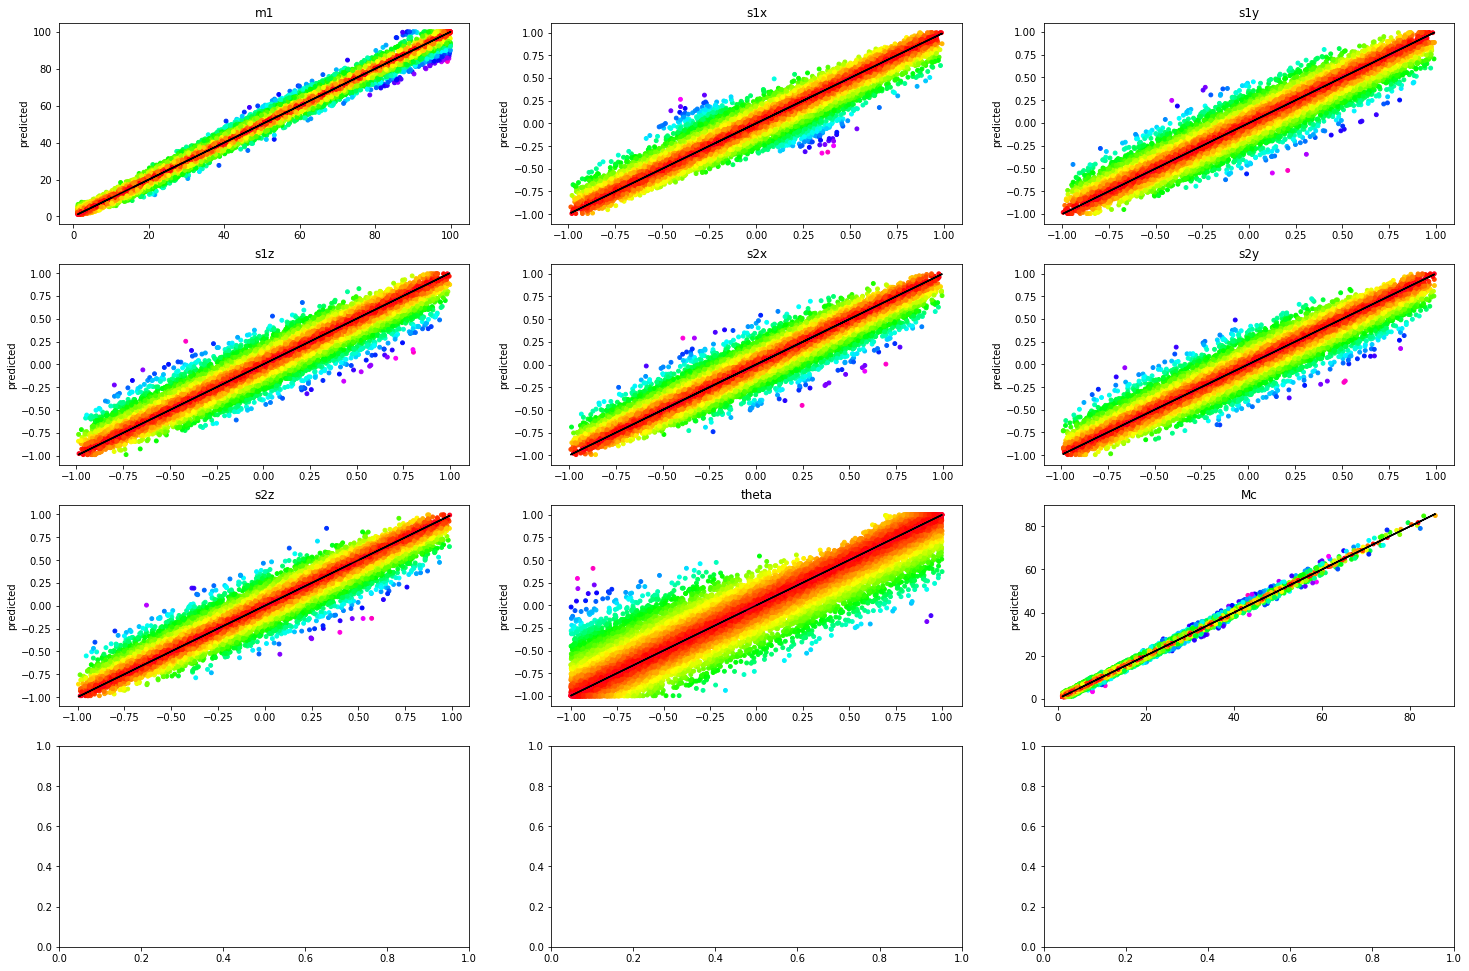

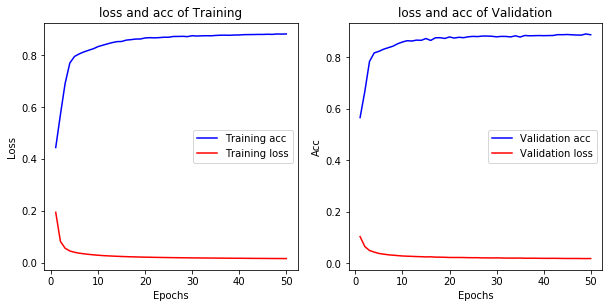

In [6]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
        
    # Load all the data for the specific version
    xtrain_notnormalized = ut.extractData(regr_data_dir+key+'train_x.csv', verbose=False)
    ytrain_notnormalized = ut.extractData(regr_data_dir+key+'train_y.csv', verbose=False)
    xtest_notnormalized  = ut.extractData(regr_data_dir+key+'test_x.csv' , verbose=False)
    ytest_notnormalized  = ut.extractData(regr_data_dir+key+'test_y.csv' , verbose=False)
    
    if remove_some_mass:
        xtrain_notnormalized, ytrain_notnormalized, labels, Nfeatures = \
            ut.RemoveSomeMassFromDataset(xtrain_notnormalized, ytrain_notnormalized, features_names, [1,9])
        xtest_notnormalized,  ytest_notnormalized ,  _, _ = \
            ut.RemoveSomeMassFromDataset(xtest_notnormalized,  ytest_notnormalized,  features_names, [1,9])
            
    # rescale
    if scaler_str=="standard":
        scaler_x = StandardScaler().fit(xtrain_notnormalized)
        scaler_y = StandardScaler().fit(ytrain_notnormalized)
    elif scaler_str=="minmax":
        scaler_x = MinMaxScaler(feature_range=(-1, 1)).fit(xtrain_notnormalized)
        scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(ytrain_notnormalized)
    elif scaler_str=="mixed":
        scaler_x = StandardScaler().fit(xtrain_notnormalized)
        scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(ytrain_notnormalized)
    else:
        print('scaler "',scaler_str,'" not recognized!',sep='')
        sys.exit()
        
    xtrain   = scaler_x.transform(xtrain_notnormalized)
    ytrain   = scaler_y.transform(ytrain_notnormalized)
    xtest    = scaler_x.transform(xtest_notnormalized)
    ytest    = scaler_y.transform(ytest_notnormalized)
    

    # build the model
    model = buildModelUsingSequential(hlayers_sizes, batch_size, Nfeatures)

    # compile 
    model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[mse, 'accuracy']
    )
    
    model.summary()
    
    # train the model
    t0 = time.perf_counter()
    history = model.fit(xtrain, ytrain, 
        epochs           = epochs, 
        batch_size       = batch_size,
        validation_split = validation_split,
        verbose          = verbose_training
    )
    train_time = time.perf_counter()-t0
    
    # predict
    ypredicted = model.predict(xtest)
    
    R2_vec = np.zeros((Nfeatures,))
    for i in range(0,Nfeatures):
         R2_vec[i] = ut.R2(ytest[:,i], ypredicted[:,i])
    
    # print some information
    metrics_dict    = {};
    metrics_results = model.evaluate(xtest, ytest, verbose=0)
    metrics_dict["loss"]   = metrics_results[0]
    metrics_dict["mse"]    = metrics_results[1]
    metrics_dict["acc"]    = metrics_results[2]
    metrics_dict["R2"]     = R2_vec
    metrics_dict["R2mean"] = np.mean(R2_vec)
    
    print('\nFinal loss     :', metrics_dict["loss"])
    print('Final mse      :', metrics_dict["mse"])
    print('Final accuracy :', metrics_dict["acc"])
    print('Final R2 mean  :', metrics_dict["R2mean"])
    for i in range(0,Nfeatures):
        print('R2[{:2d}]         : {:.5f}'.format(i,metrics_dict["R2"][i]))
        
    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    
    # plot
    ut.predictionPlots(scaler_y.inverse_transform(ytest), 
                scaler_y.inverse_transform(ypredicted), 
                labels)
    
    del model
    
    ut.plotHistory(history)

## Produce CSV files

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        ut.writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))